<a href="https://colab.research.google.com/github/mixkunanon/Quant-ML-/blob/main/stock_trend_prediction_bid_ask_quant_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction using ML/DL

In [ ]:
!pip install requests
!pip install lxml
!pip install yfinance
!pip install stldecompose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Chart drawing
import plotly as py
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#stat model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

from prophet import Prophet

## Import the Dataset from Yahoo Finance API


In [ ]:
import yfinance as yf

bp_yf = yf.Ticker("BANPU.BK")

# get all stock info
bp_yf.info

# get historical market data
hist_bp = bp_yf.history(period="1d",
                                start =  '2013-1-1',
                                end = '2023-3-31')

In [ ]:
hist_bp = hist_bp.reset_index()

In [ ]:
hist_bp.shape

(2496, 8)

In [ ]:
hist_bp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                       
---  ------        --------------  -----                       
 0   Date          2496 non-null   datetime64[ns, Asia/Bangkok]
 1   Open          2496 non-null   float64                     
 2   High          2496 non-null   float64                     
 3   Low           2496 non-null   float64                     
 4   Close         2496 non-null   float64                     
 5   Volume        2496 non-null   int64                       
 6   Dividends     2496 non-null   float64                     
 7   Stock Splits  2496 non-null   float64                     
dtypes: datetime64[ns, Asia/Bangkok](1), float64(6), int64(1)
memory usage: 156.1 KB


### OHLC Chart


In [ ]:
fig = make_subplots(rows=2, cols=1)

def plot_price(df):
    fig.add_trace(go.Ohlc(x=df.Date,
                        open=df.Open,
                        high=df.High,
                        low=df.Low,
                        close=df.Close,
                        name='Price'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

In [ ]:
plot_price(hist_bp)

### Decomposition

In [ ]:
bp_close = hist_bp['Close']
result = seasonal_decompose(bp_close, model='multiplicative',period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

<Figure size 640x480 with 0 Axes>

In [ ]:
# Select only the important features i.e. the date and price
df_bp_pp = hist_bp[["Date","Close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
df_bp_pp = df_bp_pp.rename(columns = {"Date":"ds","Close":"y"}) #renaming the columns of the dataset

#remove timezone
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(
            df[col], infer_datetime_format=True) 
        df[col] = df[col].dt.tz_localize(None) 
    return df

In [ ]:
df_bp_pp = remove_tz_from_dataframe(df_bp_pp)

In [ ]:
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(df_bp_pp) # fit the model using all data

future = m.make_future_dataframe(periods=30) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the Banpu Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpc2rrpvfa/i3xsr3qf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc2rrpvfa/dgjmbsh0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68139', 'data', 'file=/tmp/tmpc2rrpvfa/i3xsr3qf.json', 'init=/tmp/tmpc2rrpvfa/dgjmbsh0.json', 'output', 'file=/tmp/tmpc2rrpvfa/prophet_modelvi290puh/prophet_model-20230502042258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:22:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:22:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
m.plot_components(prediction)
plt.show()

### Technical indicators

In [ ]:
def ma_df(df):
    df['EMA_9'] = df['Close'].ewm(9).mean().shift()
    df['SMA_5'] = df['Close'].rolling(5).mean().shift()
    df['SMA_10'] = df['Close'].rolling(10).mean().shift()
    df['SMA_15'] = df['Close'].rolling(15).mean().shift()
    df['SMA_30'] = df['Close'].rolling(30).mean().shift()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
    fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
    fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
    fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
    fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
    fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
    fig.show()

ma_df(hist_bp)

In [ ]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

hist_bp['RSI'] = relative_strength_idx(hist_bp).fillna(0)

fig = go.Figure(go.Scatter(x=hist_bp.Date, y=hist_bp.RSI, name='RSI'))
fig.show()

In [ ]:
def macd_df(df):
    EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
    df['MACD'] = pd.Series(EMA_12 - EMA_26)
    df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
    fig.show()

macd_df(hist_bp)

## Data Prepraration

In [ ]:
hist_bp['Close'] = hist_bp['Close'].shift(-1)

In [ ]:
hist_bp = hist_bp.iloc[33:] # Because of moving averages and MACD lineh
hist_bp = hist_bp[:-1]      # Because of shifting close price

hist_bp.index = range(len(hist_bp))

In [ ]:
test_size  = 0.2
valid_size = 0.2

test_split_idx  = int(hist_bp.shape[0] * (1-test_size))
valid_split_idx = int(hist_bp.shape[0] * (1-(valid_size+test_size)))

train_df  = hist_bp.loc[:valid_split_idx].copy()
valid_df  = hist_bp.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = hist_bp.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

### Drop unnecessary columns

In [ ]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

<ipython-input-21-20c08730d5bd>:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

<ipython-input-21-20c08730d5bd>:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

<ipython-input-21-20c08730d5bd>:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



### Split into features and labels

In [ ]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478 entries, 0 to 1477
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Dividends     1478 non-null   float64
 1   Stock Splits  1478 non-null   float64
 2   EMA_9         1478 non-null   float64
 3   SMA_5         1478 non-null   float64
 4   SMA_10        1478 non-null   float64
 5   SMA_15        1478 non-null   float64
 6   SMA_30        1478 non-null   float64
 7   RSI           1478 non-null   float64
 8   MACD          1478 non-null   float64
 9   MACD_signal   1478 non-null   float64
dtypes: float64(10)
memory usage: 115.6 KB


<ipython-input-22-ded38c391784>:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

<ipython-input-22-ded38c391784>:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

<ipython-input-22-ded38c391784>:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



### Fine-tune XGBoostRegressor

In [ ]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[04:23:03] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[04:23:04] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[04:23:04] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[04:23:04] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[04:23:04] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[04:23:05] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[04:23:05] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[04:23:05] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[04:23:05] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[04:23:06] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[04:23:06] WARNING: ../src/lea

In [ ]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 815 ms, sys: 36.9 ms, total: 852 ms
Wall time: 442 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

feature importance มีขั้นตอน คือ
1. เทรน model กับข้อมูลปกติ และคำนวณค่า loss (เช่น MSE, MAE, Entropy) มาเป็น reference ไว้
2. สลับข้อมูลระหว่าง row ของ feature ที่จะคิดค่า importance และ เอาข้อมูลที่ถูกสลับนี้ไป predict ด้วย model ที่เทรนในข้อ 1 (💣สลับเพื่อทำลายความสัมพันธ์ระหว่าง feature และ target)
3. คำนวณค่า loss จากข้อ 2 เพื่อเปรียบเทียบว่าการทำลาย feature นั้นๆ ทำให้ค่า loss  มากขึ้นเท่าไหร่ และ บันทึกไว้
4. ทำแบบนี้กับทุก feature -> feature ไหนทำให้ค่า loss ขึ้นมามาก แปลว่ายิ่งสำคัญ!
😁เท่านี้เราก็แปลผลของ machine learning เพื่อการสื่อสารกับ user ได้ทางนึงแล้ว

ref : https://www.facebook.com/datawizthailand

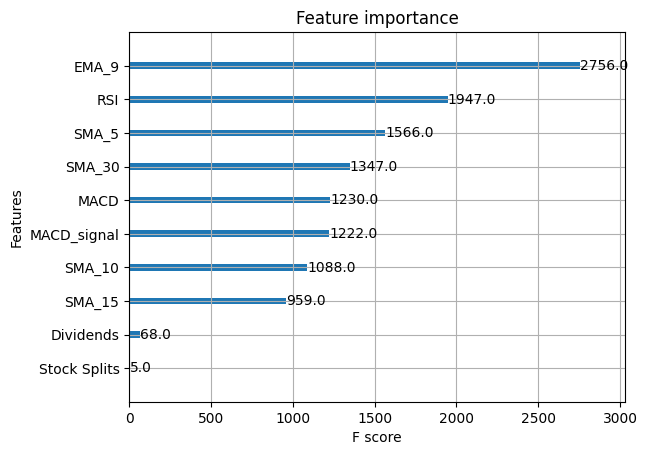

In [ ]:
plot_importance(model);

### Calculate and visualize predictions

In [ ]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [ 9.61935806 10.47822857 10.56411648 10.39234257 10.39234257]
y_pred = [ 8.657366  8.568227  9.672989  9.675821 10.608479]


In [ ]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.3482521174829655


In [ ]:
predicted_prices = hist_bp.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=hist_bp.Date, y=hist_bp.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [ ]:
predicted_prices.head()

Date       Open       High        Low      Close  \
1970 2021-03-18 00:00:00+07:00   9.705245   9.705245   9.533471   8.657366   
1971 2021-03-19 00:00:00+07:00   9.619358   9.705246   9.447584   8.568227   
1972 2021-03-22 00:00:00+07:00   9.705245  10.564116   9.619357   9.672989   
1973 2021-03-23 00:00:00+07:00  10.650003  10.821778  10.220567   9.675821   
1974 2021-03-24 00:00:00+07:00  10.306455  10.564117  10.306455  10.608479   

         Volume  Dividends  Stock Splits     EMA_9     SMA_5    SMA_10  \
1970   33715000        0.0           0.0  9.601816  9.585003  9.542059   
1971   45429000        0.0           0.0  9.612159  9.636535  9.533471   
1972  251393700        0.0           0.0  9.612879  9.688068  9.533471   
1973  196253000        0.0           0.0  9.699414  9.825487  9.645124   
1974   67576400        0.0           0.0  9.785884  9.997261  9.765366   

        SMA_15    SMA_30        RSI      MACD  MACD_signal  
1970  9.602180  9.673753  43.750009  0.035055     0.050831  
1971  9.630809  9.688067  41.176482  0.032717     0.047208  
1972  9.613632  9.702382  65.384617  0.099026     0.057572  
1973  9.653713  9.739600  66.666680  0.156700     0.077397  
1974  9.705245  9.782543  62.068985  0.186398     0.099197

In [ ]:
predicted_prices['diff'] =  predicted_prices['Close'].diff().fillna(0)

In [ ]:
diff_df = predicted_prices[['Date','diff']]

close_df = predicted_prices[['Date','Close']]

## Diff Prediction

### Day

Text(0.5, 0, 'Date')

<Figure size 2000x1000 with 0 Axes>

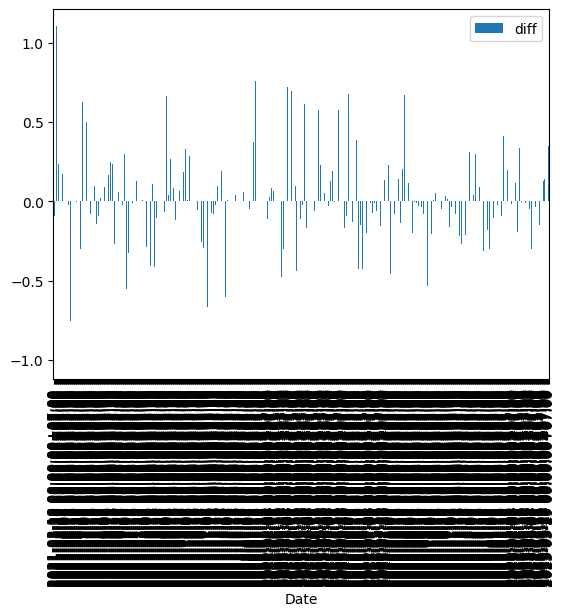

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(20, 10))
diff_df.groupby(pd.Grouper(key='Date', axis=0, 
                      freq='D')).sum().plot.bar()
plt.xlabel('Date')

### Month

<Axes: xlabel='Date'>

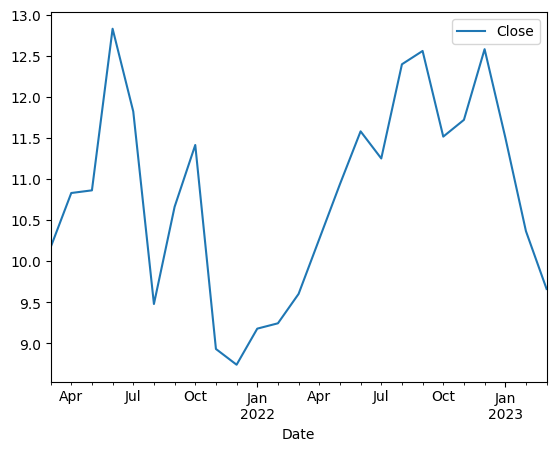

In [ ]:
close_df.groupby(pd.Grouper(key='Date', axis=0, 
                      freq='M')).mean().plot.line()

<Axes: xlabel='Date'>

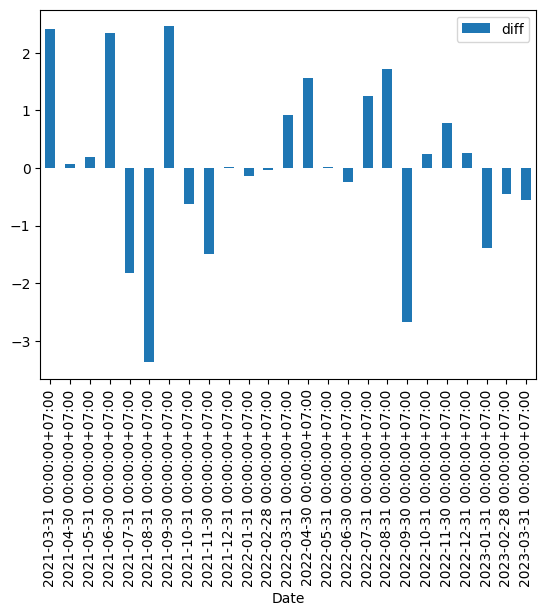

In [ ]:
diff_df.groupby(pd.Grouper(key='Date', axis=0, 
                      freq='M')).sum().plot.bar()

### Trend Prediction 

In [ ]:
truth = hist_bp.iloc[1970:][['Date','Close']]

truth.head()

Date      Close
1970 2021-03-18 00:00:00+07:00   9.619358
1971 2021-03-19 00:00:00+07:00  10.478229
1972 2021-03-22 00:00:00+07:00  10.564116
1973 2021-03-23 00:00:00+07:00  10.392343
1974 2021-03-24 00:00:00+07:00  10.392343

In [ ]:
close_df.head()

Date      Close
1970 2021-03-18 00:00:00+07:00   8.657366
1971 2021-03-19 00:00:00+07:00   8.568227
1972 2021-03-22 00:00:00+07:00   9.672989
1973 2021-03-23 00:00:00+07:00   9.675821
1974 2021-03-24 00:00:00+07:00  10.608479

In [ ]:
diff_df.head()

Date      diff
1970 2021-03-18 00:00:00+07:00  0.000000
1971 2021-03-19 00:00:00+07:00 -0.089139
1972 2021-03-22 00:00:00+07:00  1.104762
1973 2021-03-23 00:00:00+07:00  0.002832
1974 2021-03-24 00:00:00+07:00  0.932657

In [ ]:
truth_diff = truth.copy()

truth_diff['diff'] = truth_diff['Close'].diff().fillna(0)

truth_diff = truth_diff.drop(columns = 'Close')

<Axes: xlabel='Date'>

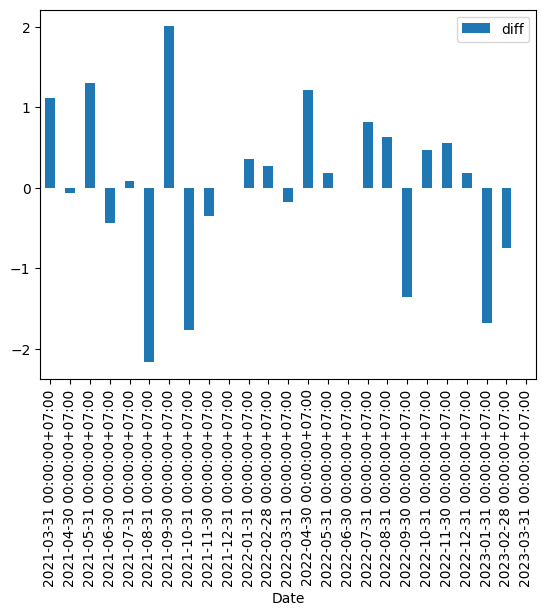

In [ ]:
truth_diff.groupby(pd.Grouper(key='Date', axis=0, 
                      freq='M')).sum().plot.bar()

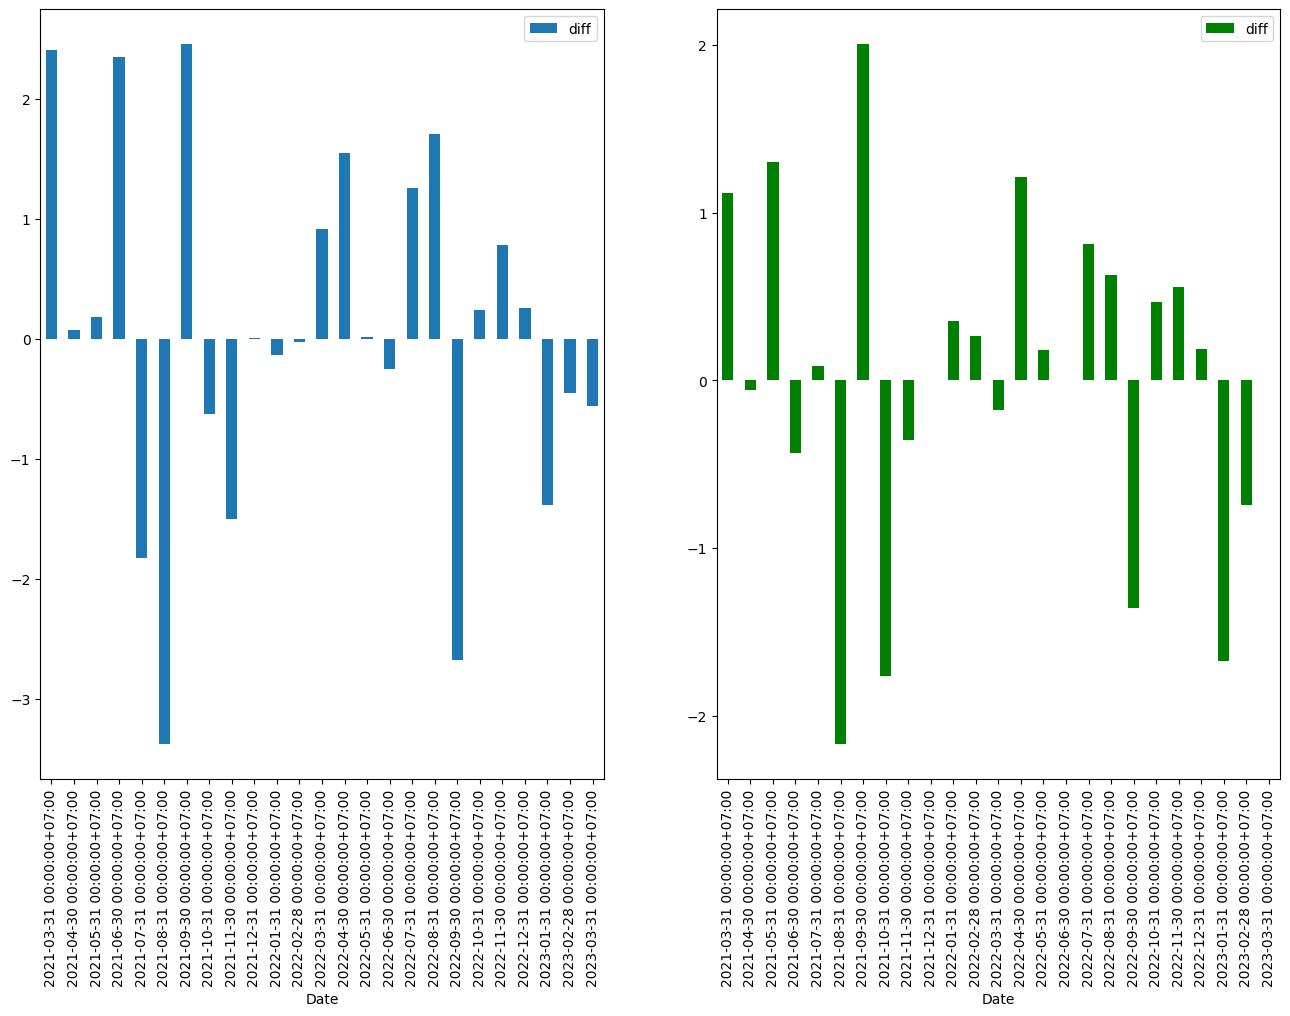

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize= (16,10))

# Plot the first dataframe on the left subplot
diff_df.groupby(pd.Grouper(key='Date', axis=0, 
                      freq='M')).sum().plot.bar(ax=ax1)

# Plot the second dataframe on the right subplot
truth_diff.groupby(pd.Grouper(key='Date', axis=0, 
                      freq='M')).sum().plot.bar(ax=ax2,
                                                            color = 'g')

# Display the plot
plt.show()

# Bid Ask

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ba_bp = pd.read_csv('/content/gdrive/MyDrive/Pi data/banpu_bidask.csv')

In [ ]:
ba_bp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199804 entries, 0 to 199803
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   _id         199804 non-null  int64  
 1   Symbol      199804 non-null  object 
 2   Time        199804 non-null  object 
 3   Ask1        199804 non-null  float64
 4   Ask2        199804 non-null  float64
 5   Ask3        199804 non-null  float64
 6   Ask4        199804 non-null  float64
 7   Ask5        199804 non-null  float64
 8   Bid1        199804 non-null  float64
 9   Bid2        199804 non-null  float64
 10  Bid3        199804 non-null  float64
 11  Bid4        199804 non-null  float64
 12  Bid5        199804 non-null  float64
 13  VolAsk1     199804 non-null  int64  
 14  VolAsk2     199804 non-null  int64  
 15  VolAsk3     199804 non-null  int64  
 16  VolAsk4     199804 non-null  int64  
 17  VolAsk5     199804 non-null  int64  
 18  VolBid1     199804 non-null  int64  
 19  Vo

In [ ]:
ba_bp.head(5)

_id Symbol                 Time  Ask1  Ask2  Ask3  Ask4  Ask5  \
0  25340700  BANPU  2021-08-27 09:55:00  10.7  10.6  10.5  10.4   0.0   
1  25340701  BANPU  2021-08-27 09:56:01  10.7  10.6  10.5  10.4   0.0   
2  25340702  BANPU  2021-08-27 09:56:02  10.9  10.8  10.7  10.6  10.5   
3  25340703  BANPU  2021-08-27 09:56:05  10.9  10.8  10.7  10.6  10.5   
4  25340704  BANPU  2021-08-27 09:56:11  10.9  10.8  10.7  10.6  10.5   

           Bid1  Bid2  ...  VolAsk2  VolAsk3  VolAsk4  VolAsk5   VolBid1  \
0  9.223372e+12  13.4  ...  7999600  5068300  1066000   393000    239700   
1  9.223372e+12  13.4  ...  7999600  5068300  1066000   393000    261200   
2  1.040000e+01  10.3  ...  7210900  8843300  8036300  2907300  10104900   
3  1.040000e+01  10.3  ...  7214300  8990700  8139700  4394800  11173900   
4  1.040000e+01  10.3  ...  7214300  8990700  8140200  4390800  11435200   

    VolBid2  VolBid3  VolBid4  VolBid5           updated_at  
0      1200      500    40000    40000  2021-08-26 00:00:00  
1      1200      500    40000    40000  2021-08-26 00:00:00  
2  14818500  9303800  7504400  4208500  2021-08-27 00:00:00  
3  14797400  9324700  7505600  4264500  2021-08-27 00:00:00  
4  14797400  9324700  7505600  4274500  2021-08-27 00:00:00  

[5 rows x 24 columns]

In [ ]:
ba_bp.describe()

_id           Ask1          Ask2           Ask3  \
count  1.998040e+05  199804.000000  1.998040e+05  199804.000000   
mean   2.544060e+07      13.156458  2.071094e+01      12.949113   
std    5.768137e+04       1.268101  3.356375e+03       1.275298   
min    2.534070e+07       0.000000  0.000000e+00       0.000000   
25%    2.539065e+07      12.600000  1.250000e+01      12.400000   
50%    2.544060e+07      13.300000  1.320000e+01      13.100000   
75%    2.549055e+07      13.900000  1.380000e+01      13.700000   
max    2.554101e+07      15.300000  1.500000e+06      15.100000   

                Ask4          Ask5          Bid1          Bid2          Bid3  \
count  199804.000000  1.998040e+05  1.998040e+05  1.998040e+05  1.998040e+05   
mean       13.058439  2.600540e+01  5.799345e+11  2.354712e+01  3.656335e+01   
std        76.326423  4.818958e+03  2.238895e+12  3.728939e+03  6.838979e+03   
min         0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%        12.300000  1.140000e+01  1.220000e+01  1.210000e+01  1.200000e+01   
50%        13.000000  1.290000e+01  1.290000e+01  1.270000e+01  1.260000e+01   
75%        13.600000  1.350000e+01  1.370000e+01  1.350000e+01  1.340000e+01   
max     30200.000000  2.000000e+06  9.223372e+12  1.555100e+06  2.593400e+06   

               Bid4  ...       VolAsk1       VolAsk2       VolAsk3  \
count  1.998040e+05  ...  1.998040e+05  1.998040e+05  1.998040e+05   
mean   2.890450e+01  ...  5.614406e+06  6.920177e+06  8.046731e+06   
std    5.029611e+03  ...  3.747059e+06  4.006825e+06  4.694760e+06   
min    0.000000e+00  ...  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.190000e+01  ...  2.909100e+06  4.038000e+06  5.248700e+06   
50%    1.250000e+01  ...  4.631100e+06  6.142400e+06  6.969450e+06   
75%    1.330000e+01  ...  8.065000e+06  9.109100e+06  9.608700e+06   
max    2.000000e+06  ...  2.472230e+07  2.472230e+07  2.497700e+07   

            VolAsk4       VolAsk5       VolBid1       VolBid2       VolBid3  \
count  1.998040e+05  1.998040e+05  1.998040e+05  1.998040e+05  1.998040e+05   
mean   9.080742e+06  6.885689e+06  6.871184e+06  8.988634e+06  7.646411e+06   
std    4.845740e+06  3.994731e+06  3.429831e+06  4.070604e+06  3.557520e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.863900e+06  4.114500e+06  4.538600e+06  6.577000e+06  5.351100e+06   
50%    8.367600e+06  6.496900e+06  6.840600e+06  9.428200e+06  7.899000e+06   
75%    1.192690e+07  8.892800e+06  8.992500e+06  1.140270e+07  9.857500e+06   
max    2.604040e+07  2.851760e+07  2.469880e+07  1.941640e+07  2.107110e+07   

            VolBid4       VolBid5  
count  1.998040e+05  1.998040e+05  
mean   6.203899e+06  5.402431e+06  
std    3.262201e+06  3.580731e+06  
min    0.000000e+00  0.000000e+00  
25%    3.999000e+06  3.329600e+06  
50%    5.853200e+06  4.954000e+06  
75%    7.979000e+06  6.857200e+06  
max    3.746160e+07  3.745930e+07  

[8 rows x 21 columns]

In [ ]:
#IQR range
Q1 = ba_bp.quantile(0.25)
Q3 = ba_bp.quantile(0.75)
IQR = Q3 - Q1

outlier_step = IQR*1.5

#print(df_train_norm < (Q1 - 1.5 * IQR)) |(df_train_norm > (Q3 + 1.5 * IQR))        
ba_bp = ba_bp[~((ba_bp < (Q1 - outlier_step)) |(ba_bp > (Q3 + outlier_step))).any(axis=1)]

<ipython-input-48-8113179a7559>:2: FutureWarning:

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-48-8113179a7559>:3: FutureWarning:

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-48-8113179a7559>:9: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



In [ ]:
ba_bp.shape

(152575, 24)

In [ ]:
ba_bp.head()

_id Symbol                 Time  Ask1  Ask2  Ask3  Ask4  Ask5  Bid1  \
2  25340702  BANPU  2021-08-27 09:56:02  10.9  10.8  10.7  10.6  10.5  10.4   
3  25340703  BANPU  2021-08-27 09:56:05  10.9  10.8  10.7  10.6  10.5  10.4   
4  25340704  BANPU  2021-08-27 09:56:11  10.9  10.8  10.7  10.6  10.5  10.4   
5  25340705  BANPU  2021-08-27 09:56:13  10.9  10.8  10.7  10.6  10.5  10.4   
6  25340706  BANPU  2021-08-27 09:56:13  10.9  10.8  10.7  10.6  10.5  10.4   

   Bid2  ...  VolAsk2  VolAsk3  VolAsk4  VolAsk5   VolBid1   VolBid2  VolBid3  \
2  10.3  ...  7210900  8843300  8036300  2907300  10104900  14818500  9303800   
3  10.3  ...  7214300  8990700  8139700  4394800  11173900  14797400  9324700   
4  10.3  ...  7214300  8990700  8140200  4390800  11435200  14797400  9324700   
5  10.3  ...  7214300  8990700  8140200  4394800  11433200  14797400  9324700   
6  10.3  ...  7214300  8990700  8140200  4394800  11433200  14797400  9324700   

   VolBid4  VolBid5           updated_at  
2  7504400  4208500  2021-08-27 00:00:00  
3  7505600  4264500  2021-08-27 00:00:00  
4  7505600  4274500  2021-08-27 00:00:00  
5  7505600  4274500  2021-08-27 00:00:00  
6  7505600  4274500  2021-08-27 00:00:00  

[5 rows x 24 columns]

In [ ]:
#datetime type
ba_bp['Time'] = pd.to_datetime(ba_bp['Time'])
#drop col
ba_bp = ba_bp.drop(columns = ['_id','Symbol'])


<ipython-input-51-f05ffd89ebc7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
ba_bp[['VolBid1','VolBid2','VolBid3','VolBid4','VolBid5','VolAsk1','VolAsk2','VolAsk3','VolAsk4','VolAsk5']].iloc[1997:2005]

ba_bp['Sum Bid'] = ba_bp['VolBid1'] + ba_bp['VolBid2'] +ba_bp['VolBid3'] +ba_bp['VolBid4'] +ba_bp['VolBid5'] 
ba_bp['Sum Ask'] = ba_bp['VolAsk1'] + ba_bp['VolAsk2'] + ba_bp['VolAsk3'] + ba_bp['VolAsk4'] + ba_bp['VolAsk5']

ba_bp['Sum Bid / Sum Ask'] = ba_bp['Sum Bid'] / ba_bp['Sum Ask']

In [ ]:
ba_bp[['VolBid1','VolBid2','VolBid3','VolBid4','VolBid5','VolAsk1','VolAsk2','VolAsk3','VolAsk4','VolAsk5','Sum Bid / Sum Ask']].iloc[1997:2005]

VolBid1   VolBid2   VolBid3  VolBid4  VolBid5  VolAsk1  VolAsk2  \
1999  13026800  15643400  11029700  7671900  5340200  3014600  5727800   
2000  13025100  15615400  11029700  7671900  5340200  3014600  5727800   
2001  13024100  15615400  11029700  7671900  5340200  3014600  5727800   
2002  13026100  15613400  11029700  7671900  5340200  3014600  5737800   
2003  13029100  15613400  11026700  7674900  5340200  3014600  5737800   
2004  13029100  15613400  11026700  7675000  5340200  3014600  5737800   
2005  13029100  15613400  11026700  7675000  5340200  3014600  5737800   
2006  13029100  15612400  11026700  7675000  5340200  3014600  5737800   

      VolAsk3   VolAsk4  VolAsk5  Sum Bid / Sum Ask  
1999  9608800  15832500  7390300           1.267908  
2000  9608800  15832500  7361000           1.268087  
2001  9608800  15832500  7361000           1.268063  
2002  9608800  15832500  7361000           1.267758  
2003  9608800  15832500  7361000           1.267830  
2004  9608800  15832500  7361000           1.267833  
2005  9608800  15832500  7361000           1.267833  
2006  9608800  15832500  7361000           1.267808

In [ ]:
ba_bp['Accum Sum'] = ba_bp['Sum Bid / Sum Ask'].cumsum()

ba_bp[['VolBid1','VolBid2','VolBid3','VolBid4','VolBid5','VolAsk1','VolAsk2','VolAsk3','VolAsk4','VolAsk5','Sum Bid / Sum Ask','Accum Sum']].iloc[1997:2005]

VolBid1   VolBid2   VolBid3  VolBid4  VolBid5  VolAsk1  VolAsk2  \
1999  13026800  15643400  11029700  7671900  5340200  3014600  5727800   
2000  13025100  15615400  11029700  7671900  5340200  3014600  5727800   
2001  13024100  15615400  11029700  7671900  5340200  3014600  5727800   
2002  13026100  15613400  11029700  7671900  5340200  3014600  5737800   
2003  13029100  15613400  11026700  7674900  5340200  3014600  5737800   
2004  13029100  15613400  11026700  7675000  5340200  3014600  5737800   
2005  13029100  15613400  11026700  7675000  5340200  3014600  5737800   
2006  13029100  15612400  11026700  7675000  5340200  3014600  5737800   

      VolAsk3   VolAsk4  VolAsk5  Sum Bid / Sum Ask    Accum Sum  
1999  9608800  15832500  7390300           1.267908  2513.442372  
2000  9608800  15832500  7361000           1.268087  2514.710459  
2001  9608800  15832500  7361000           1.268063  2515.978522  
2002  9608800  15832500  7361000           1.267758  2517.246280  
2003  9608800  15832500  7361000           1.267830  2518.514110  
2004  9608800  15832500  7361000           1.267833  2519.781942  
2005  9608800  15832500  7361000           1.267833  2521.049775  
2006  9608800  15832500  7361000           1.267808  2522.317583

<Axes: >

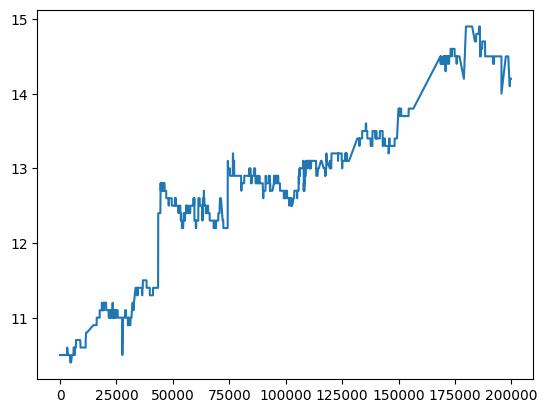

In [ ]:
ba_bp['Ask5'].plot.line()

<Axes: >

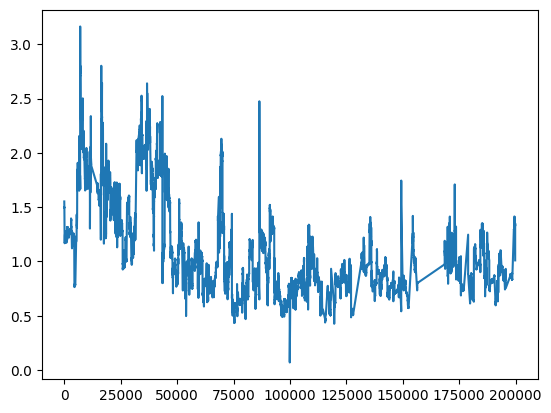

In [ ]:
ba_bp['Sum Bid / Sum Ask'].plot.line()

<Axes: >

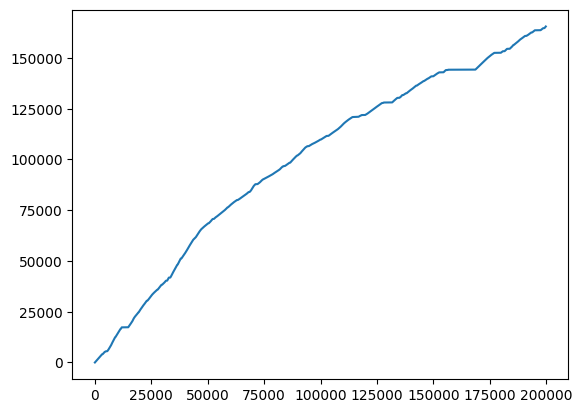

In [ ]:
ba_bp['Accum Sum'].plot.line()

In [ ]:
ba_bp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152575 entries, 2 to 199803
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Time        152575 non-null  datetime64[ns]
 1   Ask1        152575 non-null  float64       
 2   Ask2        152575 non-null  float64       
 3   Ask3        152575 non-null  float64       
 4   Ask4        152575 non-null  float64       
 5   Ask5        152575 non-null  float64       
 6   Bid1        152575 non-null  float64       
 7   Bid2        152575 non-null  float64       
 8   Bid3        152575 non-null  float64       
 9   Bid4        152575 non-null  float64       
 10  Bid5        152575 non-null  float64       
 11  VolAsk1     152575 non-null  int64         
 12  VolAsk2     152575 non-null  int64         
 13  VolAsk3     152575 non-null  int64         
 14  VolAsk4     152575 non-null  int64         
 15  VolAsk5     152575 non-null  int64         
 16  Vo

### Bid - Ask  Volume Ratio 

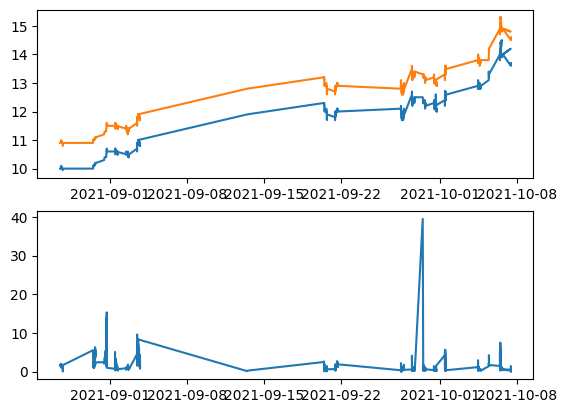

In [ ]:
ba_bp['bid5_ask1_vol_ratio'] = ba_bp['VolBid5'] / ba_bp['VolAsk1']
# Create a line chart of the bid-ask volume ratio over time

#subplot
fig,(ax1,ax2) = plt.subplots(2,1)

#plot1
ax1.plot(ba_bp['Time'],ba_bp['Bid5'])
ax1.plot(ba_bp['Time'],ba_bp['Ask1'])

#plot2
ax2.plot(ba_bp['Time'],ba_bp['bid5_ask1_vol_ratio'])


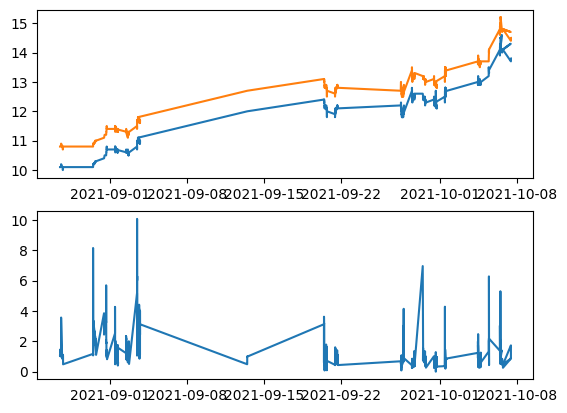

In [ ]:
ba_bp['bid4_ask2_vol_ratio'] = ba_bp['VolBid4'] / ba_bp['VolAsk2']
# Create a line chart of the bid-ask volume ratio over time

#subplot
fig,(ax1,ax2) = plt.subplots(2,1)

#plot1
ax1.plot(ba_bp['Time'],ba_bp['Bid4'])
ax1.plot(ba_bp['Time'],ba_bp['Ask2'])

#plot2
ax2.plot(ba_bp['Time'],ba_bp['bid4_ask2_vol_ratio'])

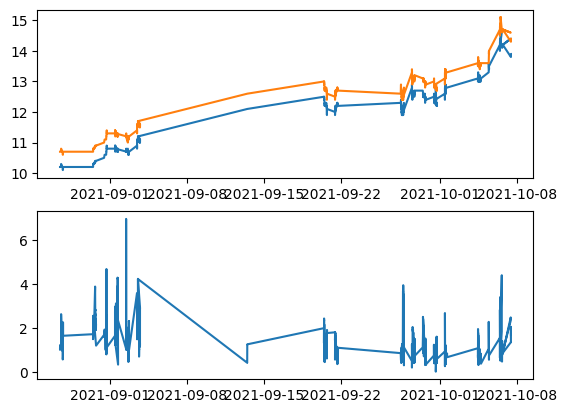

In [ ]:
ba_bp['bid3_ask3_vol_ratio'] = ba_bp['VolBid3'] / ba_bp['VolAsk3']
# Create a line chart of the bid-ask volume ratio over time

#subplot
fig,(ax1,ax2) = plt.subplots(2,1)

#plot1
ax1.plot(ba_bp['Time'],ba_bp['Bid3'])
ax1.plot(ba_bp['Time'],ba_bp['Ask3'])

#plot2
ax2.plot(ba_bp['Time'],ba_bp['bid3_ask3_vol_ratio'])

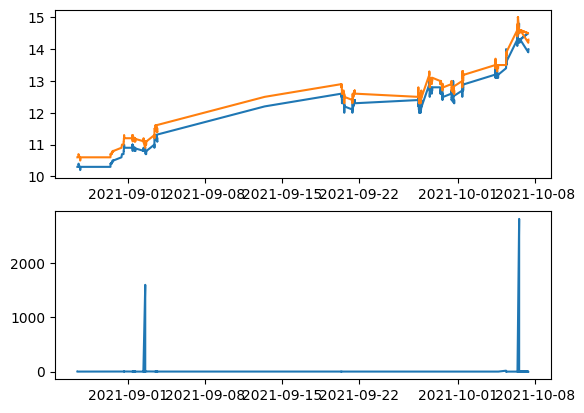

In [ ]:
ba_bp['bid2_ask4_vol_ratio'] = ba_bp['VolBid2'] / ba_bp['VolAsk4']
# Create a line chart of the bid-ask volume ratio over time

#subplot
fig,(ax1,ax2) = plt.subplots(2,1)

#plot1
ax1.plot(ba_bp['Time'],ba_bp['Bid2'])
ax1.plot(ba_bp['Time'],ba_bp['Ask4'])

#plot2
ax2.plot(ba_bp['Time'],ba_bp['bid2_ask4_vol_ratio'])

In [ ]:
ba_bp[ba_bp['bid2_ask4_vol_ratio']==ba_bp['bid2_ask4_vol_ratio'].max()]

Time  Ask1  Ask2  Ask3  Ask4  Ask5  Bid1  Bid2  Bid3  \
178960 2021-10-06 14:00:01  14.9  14.8  14.7  14.6  14.2  14.8  14.7  14.6   

        Bid4  ...  VolBid2  VolBid3  VolBid4  VolBid5           updated_at  \
178960  14.5  ...  2808600  6718700  6983500  6771800  2021-10-06 00:00:00   

        bid5_ask1_vol_ratio  bid4_ask2_vol_ratio  bid3_ask3_vol_ratio  \
178960             0.557345             1.392522             4.393317   

        bid2_ask4_vol_ratio  bid1_ask5_vol_ratio  
178960               2808.6                200.0  

[1 rows x 27 columns]

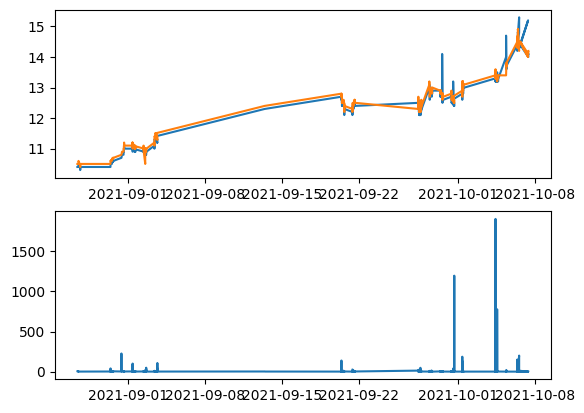

In [ ]:
ba_bp['bid1_ask5_vol_ratio'] = ba_bp['VolBid1'] / ba_bp['VolAsk5']
# Create a line chart of the bid-ask volume ratio over time

#subplot
fig,(ax1,ax2) = plt.subplots(2,1)

#plot1
ax1.plot(ba_bp['Time'],ba_bp['Bid1'])
ax1.plot(ba_bp['Time'],ba_bp['Ask5'])

#plot2
ax2.plot(ba_bp['Time'],ba_bp['bid1_ask5_vol_ratio'])

In [ ]:
ba_bp[ba_bp['bid1_ask5_vol_ratio']==ba_bp['bid1_ask5_vol_ratio'].max()]

Time  Ask1  Ask2  Ask3  Ask4  Ask5  Bid1  Bid2  Bid3  \
135617 2021-10-04 10:26:18  13.9  13.8  13.7  13.6  13.5  13.4  13.3  13.2   

        Bid4  ...   VolBid2   VolBid3  VolBid4  VolBid5           updated_at  \
135617  13.1  ...  11718600  12665000  4391900  3641700  2021-10-04 00:00:00   

        bid5_ask1_vol_ratio  bid4_ask2_vol_ratio  bid3_ask3_vol_ratio  \
135617             0.707538             0.486745             1.670337   

        bid2_ask4_vol_ratio  bid1_ask5_vol_ratio  
135617             1.105653          1903.946429  

[1 rows x 27 columns]

In [ ]:
df_pct_chg = ba_bp.set_index('Time')

df_pct_chg

Ask1  Ask2  Ask3  Ask4  Ask5  Bid1  Bid2  Bid3  Bid4  \
Time                                                                        
2021-08-27 09:56:02  10.9  10.8  10.7  10.6  10.5  10.4  10.3  10.2  10.1   
2021-08-27 09:56:05  10.9  10.8  10.7  10.6  10.5  10.4  10.3  10.2  10.1   
2021-08-27 09:56:11  10.9  10.8  10.7  10.6  10.5  10.4  10.3  10.2  10.1   
2021-08-27 09:56:13  10.9  10.8  10.7  10.6  10.5  10.4  10.3  10.2  10.1   
2021-08-27 09:56:13  10.9  10.8  10.7  10.6  10.5  10.4  10.3  10.2  10.1   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2021-10-07 09:58:56  14.6  14.5  14.4  14.3  14.2  14.1  14.0  13.9  13.8   
2021-10-07 09:58:56  14.6  14.5  14.4  14.3  14.2  14.1  14.0  13.9  13.8   
2021-10-07 09:58:56  14.6  14.5  14.4  14.3  14.2  14.1  14.0  13.9  13.8   
2021-10-07 09:58:56  14.6  14.5  14.4  14.3  14.2  14.1  14.0  13.9  13.8   
2021-10-07 09:58:56  14.6  14.5  14.4  14.3  14.2  14.1  14.0  13.9  13.8   

                     Bid5  ...   VolBid2  VolBid3  VolBid4  VolBid5  \
Time                       ...                                        
2021-08-27 09:56:02  10.0  ...  14818500  9303800  7504400  4208500   
2021-08-27 09:56:05  10.0  ...  14797400  9324700  7505600  4264500   
2021-08-27 09:56:11  10.0  ...  14797400  9324700  7505600  4274500   
2021-08-27 09:56:13  10.0  ...  14797400  9324700  7505600  4274500   
2021-08-27 09:56:13  10.0  ...  14797400  9324700  7505600  4274500   
...                   ...  ...       ...      ...      ...      ...   
2021-10-07 09:58:56  13.7  ...  11160600  9753000  6259700  9305800   
2021-10-07 09:58:56  13.7  ...  11161800  9753000  6269700  9305800   
2021-10-07 09:58:56  13.7  ...  11151800  9753000  6269700  9305800   
2021-10-07 09:58:56  13.7  ...  11151800  9753000  6269700  9305800   
2021-10-07 09:58:56  13.7  ...  11151800  9753000  6269700        9   

                              updated_at  bid5_ask1_vol_ratio  \
Time                                                            
2021-08-27 09:56:02  2021-08-27 00:00:00             1.619152   
2021-08-27 09:56:05  2021-08-27 00:00:00             1.607668   
2021-08-27 09:56:11  2021-08-27 00:00:00             1.611438   
2021-08-27 09:56:13  2021-08-27 00:00:00             1.611438   
2021-08-27 09:56:13  2021-08-27 00:00:00             1.611438   
...                                  ...                  ...   
2021-10-07 09:58:56  2021-10-07 00:00:00             1.424277   
2021-10-07 09:58:56  2021-10-07 00:00:00             1.423515   
2021-10-07 09:58:56  2021-10-07 00:00:00             1.423515   
2021-10-07 09:58:56  2021-10-07 00:00:00             1.423515   
2021-10-07 09:58:56                  NaN             0.000001   

                     bid4_ask2_vol_ratio  bid3_ask3_vol_ratio  \
Time                                                            
2021-08-27 09:56:02             1.040702             1.052073   
2021-08-27 09:56:05             1.040378             1.037149   
2021-08-27 09:56:11             1.040378             1.037149   
2021-08-27 09:56:13             1.040378             1.037149   
2021-08-27 09:56:13             1.040378             1.037149   
...                                  ...                  ...   
2021-10-07 09:58:56             0.892191             1.686437   
2021-10-07 09:58:56             0.893489             1.686437   
2021-10-07 09:58:56             0.893489             1.686437   
2021-10-07 09:58:56             0.893489             1.686437   
2021-10-07 09:58:56             0.893489             1.686437   

                     bid2_ask4_vol_ratio  bid1_ask5_vol_ratio  
Time                                                           
2021-08-27 09:56:02             1.843946             3.475699  
2021-08-27 09:56:05             1.817929             2.542528  
2021-08-27 09:56:11             1.817818             2.604355  
2021-08-27 09:56:13             1.817818             2.601529  
2021-08-27 09:56:13

In [ ]:
ิิ

In [ ]:
# Calculate the percent change in the data
df_pct_change = ba_bp['Bid5'].pct_change()

df_pct_change

2         NaN
3         0.0
4         0.0
5         0.0
6         0.0
         ... 
199799    0.0
199800    0.0
199801    0.0
199802    0.0
199803    0.0
Name: Bid5, Length: 152575, dtype: float64

The formula for calculating the Bid/Ask Volume Cross Oscillator is as follows:

Bid/Ask Volume Cross Oscillator = [(Total Bid Volume - Total Ask Volume) / (Total Bid Volume + Total Ask Volume)] x 100

In [ ]:
#BAVolCr = (Bid Volume - Ask Volume) / (Bid Volume + Ask Volume)
ba1 = ba_bp[['Time','Ask1','Bid5','VolAsk1','VolBid5']].reset_index(drop=True)

ba1.head()

Time  Ask1  Bid5  VolAsk1  VolBid5
0 2021-08-27 09:56:02  10.9  10.0  2599200  4208500
1 2021-08-27 09:56:05  10.9  10.0  2652600  4264500
2 2021-08-27 09:56:11  10.9  10.0  2652600  4274500
3 2021-08-27 09:56:13  10.9  10.0  2652600  4274500
4 2021-08-27 09:56:13  10.9  10.0  2652600  4274500

In [ ]:

#bid -ask cross
ba1['BAVolCr']  = (ba1['VolBid5'] - ba1['VolAsk1']) / (ba1['VolBid5'] + ba1['VolAsk1'])

#weight average pricv
ba1['WAP'] = (ba1['Bid5'] * ba1['VolAsk1'] +
                                ba1['Ask1'] * ba1['VolBid5']) / (
                                ba1['VolBid5']+ ba1['VolAsk1'])

In [ ]:
ba1.head()

Time  Ask1  Bid5  VolAsk1  VolBid5   BAVolCr        WAP
0 2021-08-27 09:56:02  10.9  10.0  2599200  4208500  0.236394  10.556377
1 2021-08-27 09:56:05  10.9  10.0  2652600  4264500  0.233031  10.554864
2 2021-08-27 09:56:11  10.9  10.0  2652600  4274500  0.234138  10.555362
3 2021-08-27 09:56:13  10.9  10.0  2652600  4274500  0.234138  10.555362
4 2021-08-27 09:56:13  10.9  10.0  2652600  4274500  0.234138  10.555362

### WAP

<Axes: xlabel='Time'>

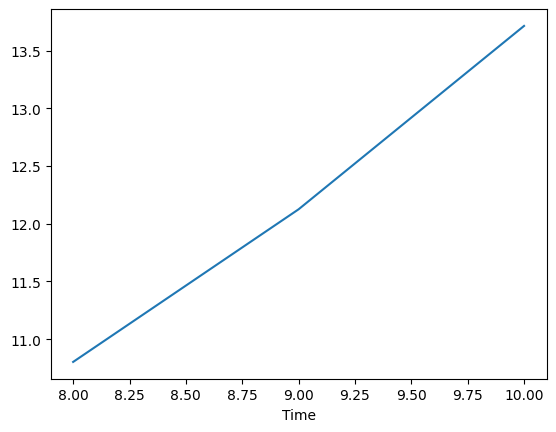

In [ ]:
%matplotlib inline
#month wap plot
ba1.groupby(ba1.Time.dt.month)['WAP'].mean().plot.line()

<Axes: xlabel='Time'>

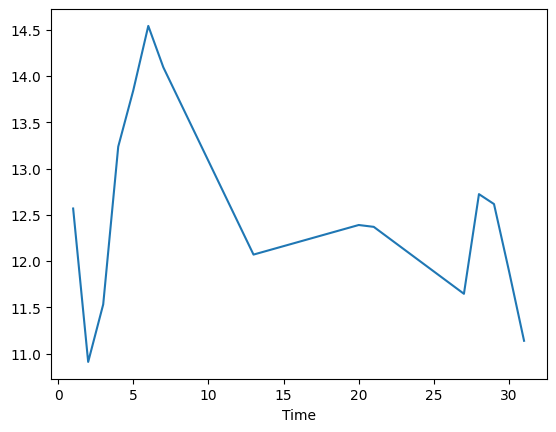

In [ ]:
#day หุ้นราคาสูงช่วงไหนวันไหนของเดือน
ba1.groupby(ba1.Time.dt.day)['WAP'].mean().plot.line()

<Axes: xlabel='Time'>

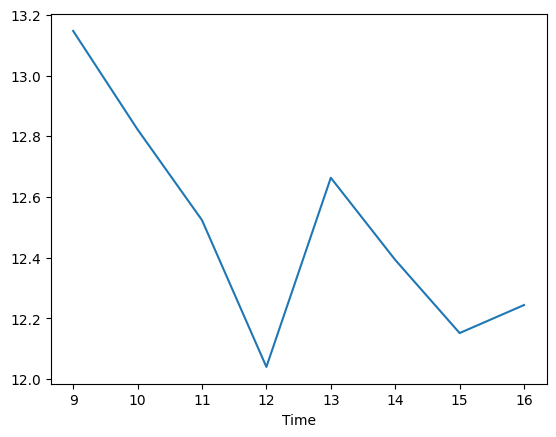

In [ ]:
#WAP หุ้นราคาเป็นอย่างไรระหว่างวัน
ba1.groupby(ba1.Time.dt.hour)['WAP'].mean().plot.line()

### Bid Ask Vol Ratio

<Axes: xlabel='Time'>

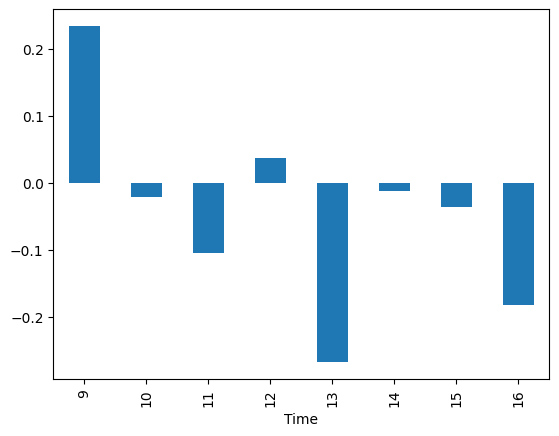

In [ ]:
#hour
ba1.groupby(ba1.Time.dt.hour)['BAVolCr'].mean().plot.bar()

### Log Retrun

In [ ]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

ba1.loc[:,'log_return'] = log_return(ba1['WAP'])
ba1 = ba1[~ba1['log_return'].isnull()]


In [ ]:
ba1

Time  Ask1  Bid5  VolAsk1  VolBid5   BAVolCr        WAP  \
1      2021-08-27 09:56:05  10.9  10.0  2652600  4264500  0.233031  10.554864   
2      2021-08-27 09:56:11  10.9  10.0  2652600  4274500  0.234138  10.555362   
3      2021-08-27 09:56:13  10.9  10.0  2652600  4274500  0.234138  10.555362   
4      2021-08-27 09:56:13  10.9  10.0  2652600  4274500  0.234138  10.555362   
5      2021-08-27 09:56:14  10.9  10.0  2652600  4274500  0.234138  10.555362   
...                    ...   ...   ...      ...      ...       ...        ...   
152570 2021-10-07 09:58:56  14.6  13.7  6533700  9305800  0.175012  14.228755   
152571 2021-10-07 09:58:56  14.6  13.7  6537200  9305800  0.174752  14.228639   
152572 2021-10-07 09:58:56  14.6  13.7  6537200  9305800  0.174752  14.228639   
152573 2021-10-07 09:58:56  14.6  13.7  6537200  9305800  0.174752  14.228639   
152574 2021-10-07 09:58:56  14.6  13.7  6537200        9 -0.999997  13.700001   

        log_return  
1        -0.000143  
2         0.000047  
3         0.000000  
4         0.000000  
5         0.000000  
...            ...  
152570    0.000000  
152571   -0.000008  
152572    0.000000  
152573    0.000000  
152574   -0.037861  

[152574 rows x 8 columns]

In [ ]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

realized_vol = realized_volatility(ba1['log_return'])
print(f'BANPU is {realized_vol}')

BANPU is 0.4503781603234852


In [ ]:
# colors 
mycolors = ['#739900', '#b31aff']
bidask_color = ['#cc0000', '#006699']

In [ ]:
# bid-ask spread
ba1['spread'] = ba1['Ask1'] - ba1['Bid5']
# minimum bid-ask spread
idx = np.argmin(ba1['spread'])

In [ ]:
ba1.head()

Time  Ask1  Bid5  VolAsk1  VolBid5   BAVolCr        WAP  \
1 2021-08-27 09:56:05  10.9  10.0  2652600  4264500  0.233031  10.554864   
2 2021-08-27 09:56:11  10.9  10.0  2652600  4274500  0.234138  10.555362   
3 2021-08-27 09:56:13  10.9  10.0  2652600  4274500  0.234138  10.555362   
4 2021-08-27 09:56:13  10.9  10.0  2652600  4274500  0.234138  10.555362   
5 2021-08-27 09:56:14  10.9  10.0  2652600  4274500  0.234138  10.555362   

   log_return  spread  
1   -0.000143     0.9  
2    0.000047     0.9  
3    0.000000     0.9  
4    0.000000     0.9  
5    0.000000     0.9

In [ ]:
ba1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152574 entries, 1 to 152574
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Time        152574 non-null  datetime64[ns]
 1   Ask1        152574 non-null  float64       
 2   Bid5        152574 non-null  float64       
 3   VolAsk1     152574 non-null  int64         
 4   VolBid5     152574 non-null  int64         
 5   BAVolCr     152574 non-null  float64       
 6   WAP         152574 non-null  float64       
 7   log_return  152574 non-null  float64       
 8   spread      152574 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 11.6 MB


<Axes: >

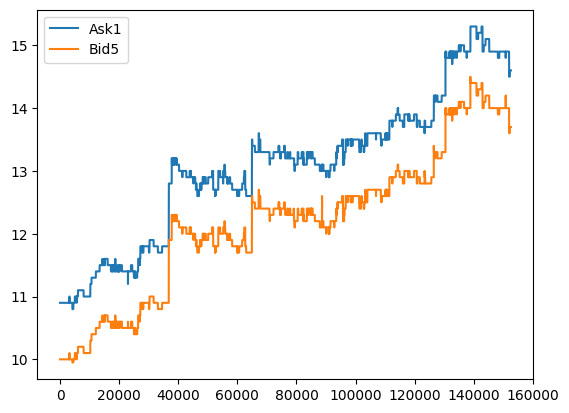

In [ ]:
ba1[['Ask1','Bid5']].plot.line()

<Axes: >

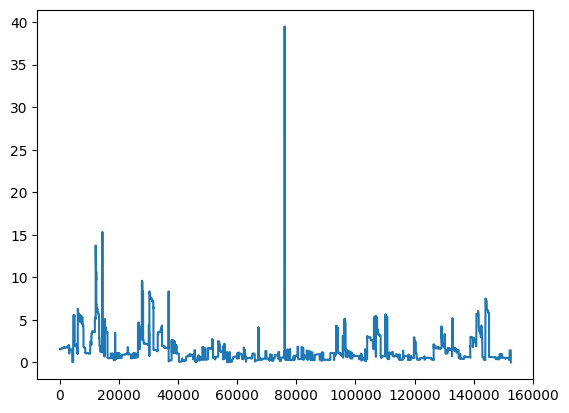

In [ ]:
ba1['BA_ratio'].plot.line()

In [ ]:
ba1[ba1['BA_ratio'] == ba1['BA_ratio'].max()]

Time  Ask1  Bid5  VolAsk1  VolBid5   BAVolCr        WAP  \
76040 2021-09-29 09:30:01  13.3  12.5    38000  1500000  0.950585  13.280234   

       log_return  spread  net_size  net   BA_ratio  
76040    0.020454     0.8   1462000  pos  39.473684

### Bid/Ask Anomaly

In [ ]:
ba1[ba1['spread'] == ba1['spread'].min()]

Time  Ask1  Bid5   VolAsk1  VolBid5   BAVolCr  \
88644  2021-09-30 14:00:06  13.0  12.6  11743700  2261400 -0.677060   
88645  2021-09-30 14:00:06  13.0  12.6  11743700  2261400 -0.677060   
88646  2021-09-30 14:00:07  13.0  12.6  11743700  2261400 -0.677060   
88647  2021-09-30 14:00:07  13.0  12.6  11743700  2261400 -0.677060   
88648  2021-09-30 14:00:07  13.0  12.6  11743700  2261400 -0.677060   
88649  2021-09-30 14:00:07  13.0  12.6  11743700  2261400 -0.677060   
88650  2021-09-30 14:00:07  13.0  12.6  11743700  2261400 -0.677060   
88651  2021-09-30 14:00:08  13.0  12.6  11744700  2261400 -0.677084   
88652  2021-09-30 14:00:08  13.0  12.6  11744700  2261500 -0.677072   
88653  2021-09-30 14:00:10  13.0  12.6  11745000  2261500 -0.677078   
88654  2021-09-30 14:00:10  13.0  12.6  11745000  2261500 -0.677078   
88655  2021-09-30 14:00:11  13.0  12.6  11745000  2265500 -0.676600   
88656  2021-09-30 14:00:12  13.0  12.6  11745500  2265800 -0.676575   
88657  2021-09-30 14:00:13  13.0  12.6  11745500  2273800 -0.675619   
88658  2021-09-30 14:00:13  13.0  12.6  11745500  2273800 -0.675619   
88659  2021-09-30 14:00:14  13.0  12.6  11745500  2273800 -0.675619   
88660  2021-09-30 14:00:14  13.0  12.6  11745500  2273900 -0.675607   
88661  2021-09-30 14:00:14  13.0  12.6  11745500  2273900 -0.675607   
88662  2021-09-30 14:00:14  13.0  12.6  11745500  2273900 -0.675607   
88663  2021-09-30 14:00:15  13.0  12.6  11745500  2273900 -0.675607   
88664  2021-09-30 14:00:15  13.0  12.6  11745500  2273900 -0.675607   
88665  2021-09-30 14:00:15  13.0  12.6  11745500  2273900 -0.675607   
126470 2021-10-05 09:30:02  13.8  13.4   1019700  2184700  0.363563   
138848 2021-10-06 14:00:01  14.9  14.5  12159800  6985500 -0.270265   
138849 2021-10-06 14:00:02  14.9  14.5  12170400  6986900 -0.270576   

              WAP    log_return  spread  net_size  net  BA_ratio  
88644   12.664588  7.790434e-03     0.4  -9482300  neg  0.192563  
88645   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563  
88646   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563  
88647   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563  
88648   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563  
88649   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563  
88650   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563  
88651   12.664583 -3.641187e-07     0.4  -9483300  neg  0.192546  
88652   12.664586  1.890921e-07     0.4  -9483200  neg  0.192555  
88653   12.664584 -1.092287e-07     0.4  -9483500  neg  0.192550  
88654   12.664584  0.000000e+00     0.4  -9483500  neg  0.192550  
88655   12.664680  7.561312e-06     0.4  -9479500  neg  0.192891  
88656   12.664685  3.846518e-07     0.4  -9479700  neg  0.192908  
88657   12.664876  1.510842e-05     0.4  -9471700  neg  0.193589  
88658   12.664876  0.000000e+00     0.4  -9471700  neg  0.193589  
88659   12.664876  0.000000e+00     0.4  -9471700  neg  0.193589  
88660   12.664879  1.887447e-07     0.4  -9471600  neg  0.193598  
88661   12.664879  0.000000e+00     0.4  -9471600  neg  0.193598  
88662   12.664879  0.000000e+00     0.4  -9471600  neg  0.193598  
88663   12.664879  0.000000e+00     0.4  -9471600  neg  0.193598  
88664   12.664879  0.000000e+00     0.4  -9471600  neg  0.193598  
88665   12.664879  0.000000e+00     0.4  -9471600  neg  0.193598  
126470  13.672713  1.203920e-02     0.4   1165000  pos  2.142493  
138848  14.645947  4.585568e-03     0.4  -5174300  neg  0.574475  
138849  14.645885 -4.246135e-06     0.4  -5183500  neg  0.574090

In [ ]:
#plot wap price  change
ba1['WAP pct change'] = ba1['WAP'].pct_change()

<Axes: >

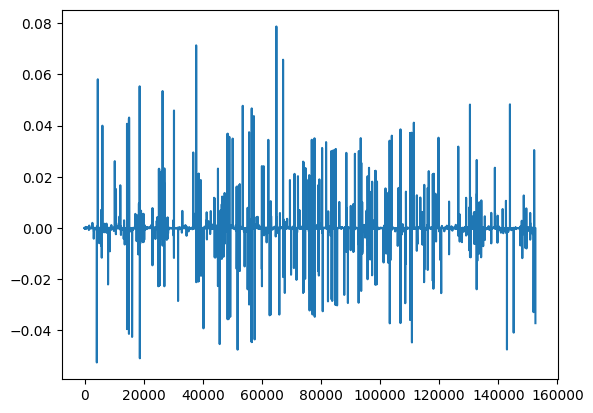

In [ ]:
ba1['WAP pct change'].plot.line()

In [ ]:
# Calculate the mean and standard deviation of the data
mean_ba = ba1['WAP pct change'].mean()
std_ba = ba1['WAP pct change'].std()

# Filter the DataFrame to include only data within 2 standard deviations of the mean
lower_bound = mean_ba - 3 * std_ba
upper_bound = mean_ba + 3 * std_ba
ba1_filter = ba1.loc[(ba1['WAP pct change'] >= lower_bound) & (ba1['WAP pct change'] <= upper_bound)]

# Print the filtered DataFrame
ba1_filter

Time  Ask1  Bid5  VolAsk1  VolBid5   BAVolCr        WAP  \
2      2021-08-27 09:56:11  10.9  10.0  2652600  4274500  0.234138  10.555362   
3      2021-08-27 09:56:13  10.9  10.0  2652600  4274500  0.234138  10.555362   
4      2021-08-27 09:56:13  10.9  10.0  2652600  4274500  0.234138  10.555362   
5      2021-08-27 09:56:14  10.9  10.0  2652600  4274500  0.234138  10.555362   
6      2021-08-27 09:56:14  10.9  10.0  2652600  4274500  0.234138  10.555362   
...                    ...   ...   ...      ...      ...       ...        ...   
152569 2021-10-07 09:58:56  14.6  13.7  6533700  9305800  0.175012  14.228755   
152570 2021-10-07 09:58:56  14.6  13.7  6533700  9305800  0.175012  14.228755   
152571 2021-10-07 09:58:56  14.6  13.7  6537200  9305800  0.174752  14.228639   
152572 2021-10-07 09:58:56  14.6  13.7  6537200  9305800  0.174752  14.228639   
152573 2021-10-07 09:58:56  14.6  13.7  6537200  9305800  0.174752  14.228639   

        log_return  spread  net_size  net  BA_ratio  WAP pct.chage  \
2         0.000047     0.9   1621900  pos  1.611438       0.000047   
3         0.000000     0.9   1621900  pos  1.611438       0.000000   
4         0.000000     0.9   1621900  pos  1.611438       0.000000   
5         0.000000     0.9   1621900  pos  1.611438       0.000000   
6         0.000000     0.9   1621900  pos  1.611438       0.000000   
...            ...     ...       ...  ...       ...            ...   
152569    0.000000     0.9   2772100  pos  1.424277       0.000000   
152570    0.000000     0.9   2772100  pos  1.424277       0.000000   
152571   -0.000008     0.9   2768600  pos  1.423515      -0.000008   
152572    0.000000     0.9   2768600  pos  1.423515       0.000000   
152573    0.000000     0.9   2768600  pos  1.423515       0.000000   

        WAP pct change  
2             0.000047  
3             0.000000  
4             0.000000  
5             0.000000  
6             0.000000  
...                ...  
152569        0.000000  
152570        0.000000  
152571       -0.000008  
152572        0.000000  
152573        0.000000  

[152189 rows x 14 columns]

In [ ]:
#statistic analysis 
ba1[ba1['WAP pct change'] == ba1['WAP pct change'].max()]

Time  Ask1  Bid5  VolAsk1  VolBid5   BAVolCr        WAP  \
64919 2021-09-28 10:03:47  13.5  12.6  7814500  4407600 -0.278749  12.924563   

       log_return  spread  net_size  net  BA_ratio  WAP pct.chage  \
64919    0.075755     0.9  -3406900  neg  0.564028       0.078698   

       WAP pct change  
64919        0.078698

In [ ]:
ba1['spread'].value_counts(sort = True)

0.90    128279
0.90     23912
0.85       330
0.40        25
1.00        11
0.60         8
0.70         4
0.60         2
0.80         1
0.80         1
0.50         1
Name: spread, dtype: int64

In [ ]:
filtered_spread= ba1.loc[(ba1['spread'] >= 0.4) & (ba1['spread'] <= 0.5)]

filtered_spread

Time  Ask1  Bid5   VolAsk1  VolBid5   BAVolCr  \
88644  2021-09-30 14:00:06  13.0  12.6  11743700  2261400 -0.677060   
88645  2021-09-30 14:00:06  13.0  12.6  11743700  2261400 -0.677060   
88646  2021-09-30 14:00:07  13.0  12.6  11743700  2261400 -0.677060   
88647  2021-09-30 14:00:07  13.0  12.6  11743700  2261400 -0.677060   
88648  2021-09-30 14:00:07  13.0  12.6  11743700  2261400 -0.677060   
88649  2021-09-30 14:00:07  13.0  12.6  11743700  2261400 -0.677060   
88650  2021-09-30 14:00:07  13.0  12.6  11743700  2261400 -0.677060   
88651  2021-09-30 14:00:08  13.0  12.6  11744700  2261400 -0.677084   
88652  2021-09-30 14:00:08  13.0  12.6  11744700  2261500 -0.677072   
88653  2021-09-30 14:00:10  13.0  12.6  11745000  2261500 -0.677078   
88654  2021-09-30 14:00:10  13.0  12.6  11745000  2261500 -0.677078   
88655  2021-09-30 14:00:11  13.0  12.6  11745000  2265500 -0.676600   
88656  2021-09-30 14:00:12  13.0  12.6  11745500  2265800 -0.676575   
88657  2021-09-30 14:00:13  13.0  12.6  11745500  2273800 -0.675619   
88658  2021-09-30 14:00:13  13.0  12.6  11745500  2273800 -0.675619   
88659  2021-09-30 14:00:14  13.0  12.6  11745500  2273800 -0.675619   
88660  2021-09-30 14:00:14  13.0  12.6  11745500  2273900 -0.675607   
88661  2021-09-30 14:00:14  13.0  12.6  11745500  2273900 -0.675607   
88662  2021-09-30 14:00:14  13.0  12.6  11745500  2273900 -0.675607   
88663  2021-09-30 14:00:15  13.0  12.6  11745500  2273900 -0.675607   
88664  2021-09-30 14:00:15  13.0  12.6  11745500  2273900 -0.675607   
88665  2021-09-30 14:00:15  13.0  12.6  11745500  2273900 -0.675607   
126470 2021-10-05 09:30:02  13.8  13.4   1019700  2184700  0.363563   
138847 2021-10-06 14:00:01  14.9  14.4  12150100  6771800 -0.284237   
138848 2021-10-06 14:00:01  14.9  14.5  12159800  6985500 -0.270265   
138849 2021-10-06 14:00:02  14.9  14.5  12170400  6986900 -0.270576   

              WAP    log_return  spread  net_size  net  BA_ratio  \
88644   12.664588  7.790434e-03     0.4  -9482300  neg  0.192563   
88645   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563   
88646   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563   
88647   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563   
88648   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563   
88649   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563   
88650   12.664588  0.000000e+00     0.4  -9482300  neg  0.192563   
88651   12.664583 -3.641187e-07     0.4  -9483300  neg  0.192546   
88652   12.664586  1.890921e-07     0.4  -9483200  neg  0.192555   
88653   12.664584 -1.092287e-07     0.4  -9483500  neg  0.192550   
88654   12.664584  0.000000e+00     0.4  -9483500  neg  0.192550   
88655   12.664680  7.561312e-06     0.4  -9479500  neg  0.192891   
88656   12.664685  3.846518e-07     0.4  -9479700  neg  0.192908   
88657   12.664876  1.510842e-05     0.4  -9471700  neg  0.193589   
88658   12.664876  0.000000e+00     0.4  -9471700  neg  0.193589   
88659   12.664876  0.000000e+00     0.4  -9471700  neg  0.193589   
88660   12.664879  1.887447e-07     0.4  -9471600  neg  0.193598   
88661   12.664879  0.000000e+00     0.4  -9471600  neg  0.193598   
88662   12.664879  0.000000e+00     0.4  -9471600  neg  0.193598   
88663   12.664879  0.000000e+00     0.4  -9471600  neg  0.193598   
88664   12.664879  0.000000e+00     0.4  -9471600  neg  0.193598   
88665   12.664879  0.000000e+00     0.4  -9471600  neg  0.193598   
126470  13.672713  1.203920e-02     0.4   1165000  pos  2.142493   
138847  14.578941  1.551971e-02     0.5  -5378300  neg  0.557345   
138848  14.645947  4.585568e-03     0.4  -5174300  neg  0.574475   
138849  14.645885 -4.246135e-06     0.4  -5183500  neg  0.574090   

        WAP pct.chage  WAP pct change  
88644    7.820858e-03    7.820858e-03  
88645    0.000000e+00    0.000000e+00  
88646    0.000000e+00    0.000000e+00  
88647    0.000000e+00    0.000000e+00  
88648    0.000000e+00    0.000000e+00  
88649    0.000000e+00    0.

<Axes: ylabel='Frequency'>

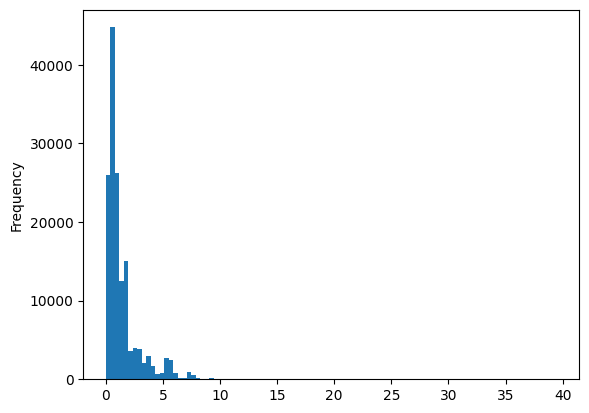

In [ ]:
ba1['BA_ratio'].plot.hist(bins = 100)

In [ ]:
#filter between date ในช่วงที่เกิดการ spread เปลี่ยน
ba_anomaly = ba1.iloc[126469:138847]

ba_anomaly

Time  Ask1  Bid5   VolAsk1  VolBid5   BAVolCr  \
126470 2021-10-05 09:30:02  13.8  13.4   1019700  2184700  0.363563   
126471 2021-10-05 10:04:05  14.2  13.3   4030700  6880400  0.261174   
126472 2021-10-05 10:04:05  14.2  13.3   4036500  6880400  0.260504   
126473 2021-10-05 10:04:06  14.2  13.3   4036500  6880400  0.260504   
126474 2021-10-05 10:04:06  14.2  13.3   4036500  6880400  0.260504   
...                    ...   ...   ...       ...      ...       ...   
138843 2021-10-06 10:21:39  14.9  14.0  10331100  6711500 -0.212385   
138844 2021-10-06 10:21:40  14.9  14.0  10331100  6711500 -0.212385   
138845 2021-10-06 10:21:40  14.9  14.0  10331100  6711500 -0.212385   
138846 2021-10-06 10:21:40  14.9  14.0  10331100  6711500 -0.212385   
138847 2021-10-06 14:00:01  14.9  14.4  12150100  6771800 -0.284237   

              WAP  log_return  spread  net_size  net  BA_ratio  WAP pct.chage  \
126470  13.672713    0.012039     0.4   1165000  pos  2.142493       0.012112   
126471  13.867528    0.014148     0.9   2849700  pos  1.706999       0.014249   
126472  13.867227   -0.000022     0.9   2843900  pos  1.704546      -0.000022   
126473  13.867227    0.000000     0.9   2843900  pos  1.704546       0.000000   
126474  13.867227    0.000000     0.9   2843900  pos  1.704546       0.000000   
...           ...         ...     ...       ...  ...       ...            ...   
138843  14.354427    0.000000     0.9  -3619600  neg  0.649640       0.000000   
138844  14.354427    0.000000     0.9  -3619600  neg  0.649640       0.000000   
138845  14.354427    0.000000     0.9  -3619600  neg  0.649640       0.000000   
138846  14.354427    0.000000     0.9  -3619600  neg  0.649640       0.000000   
138847  14.578941    0.015520     0.5  -5378300  neg  0.557345       0.015641   

        WAP pct change  
126470        0.012112  
126471        0.014249  
126472       -0.000022  
126473        0.000000  
126474        0.000000  
...                ...  
138843        0.000000  
138844        0.000000  
138845        0.000000  
138846        0.000000  
138847        0.015641  

[12378 rows x 14 columns]

In [ ]:
#ดู bid / ask ก่อนหน้านั้นค่าเป็นอย่างไร
ba1.iloc[126000:126470]

Time  Ask1  Bid5   VolAsk1  VolBid5   BAVolCr  \
126001 2021-10-04 16:20:10  13.8  12.9  12080700  4216600 -0.482540   
126002 2021-10-04 16:20:11  13.8  12.9  12080700  4216600 -0.482540   
126003 2021-10-04 16:20:12  13.8  12.9  12080700  4216600 -0.482540   
126004 2021-10-04 16:20:12  13.8  12.9  12080700  4216600 -0.482540   
126005 2021-10-04 16:20:19  13.8  12.9  12080700  4216600 -0.482540   
...                    ...   ...   ...       ...      ...       ...   
126466 2021-10-04 16:36:35  13.8  12.9  11666700  3181900 -0.571421   
126467 2021-10-04 16:36:36  13.8  12.9  11666700  3181900 -0.571421   
126468 2021-10-04 16:36:37  13.8  12.9  11666700  3181900 -0.571421   
126469 2021-10-05 09:30:01  13.8  13.1    800000  1125000  0.168831   
126470 2021-10-05 09:30:02  13.8  13.4   1019700  2184700  0.363563   

              WAP  log_return  spread  net_size  net  BA_ratio  WAP pct.chage  \
126001  13.132857    0.000033     0.9  -7864100  neg  0.349036       0.000033   
126002  13.132857    0.000000     0.9  -7864100  neg  0.349036       0.000000   
126003  13.132857    0.000000     0.9  -7864100  neg  0.349036       0.000000   
126004  13.132857    0.000000     0.9  -7864100  neg  0.349036       0.000000   
126005  13.132857    0.000000     0.9  -7864100  neg  0.349036       0.000000   
...           ...         ...     ...       ...  ...       ...            ...   
126466  13.092861    0.000000     0.9  -8484800  neg  0.272734       0.000000   
126467  13.092861    0.000000     0.9  -8484800  neg  0.272734       0.000000   
126468  13.092861    0.000000     0.9  -8484800  neg  0.272734       0.000000   
126469  13.509091    0.031296     0.7    325000  pos  1.406250       0.031791   
126470  13.672713    0.012039     0.4   1165000  pos  2.142493       0.012112   

        WAP pct change  
126001        0.000033  
126002        0.000000  
126003        0.000000  
126004        0.000000  
126005        0.000000  
...                ...  
126466        0.000000  
126467        0.000000  
126468        0.000000  
126469        0.031791  
126470        0.012112  

[470 rows x 14 columns]

In [ ]:
#ิbid / ask หลังจากนั้นเป็นไงบ้าง
ba1.iloc[138847:]

Time  Ask1  Bid5   VolAsk1  VolBid5   BAVolCr  \
138848 2021-10-06 14:00:01  14.9  14.5  12159800  6985500 -0.270265   
138849 2021-10-06 14:00:02  14.9  14.5  12170400  6986900 -0.270576   
138850 2021-10-06 11:28:05  15.3  14.4   3340900  6383000  0.312848   
138851 2021-10-06 11:28:06  15.3  14.4   3340900  6383000  0.312848   
138852 2021-10-06 11:28:07  15.3  14.4   3340900  6383000  0.312848   
...                    ...   ...   ...       ...      ...       ...   
152570 2021-10-07 09:58:56  14.6  13.7   6533700  9305800  0.175012   
152571 2021-10-07 09:58:56  14.6  13.7   6537200  9305800  0.174752   
152572 2021-10-07 09:58:56  14.6  13.7   6537200  9305800  0.174752   
152573 2021-10-07 09:58:56  14.6  13.7   6537200  9305800  0.174752   
152574 2021-10-07 09:58:56  14.6  13.7   6537200        9 -0.999997   

              WAP  log_return  spread  net_size  net  BA_ratio  WAP pct.chage  \
138848  14.645947    0.004586     0.4  -5174300  neg  0.574475       0.004596   
138849  14.645885   -0.000004     0.4  -5183500  neg  0.574090      -0.000004   
138850  14.990781    0.023276     0.9   3042100  pos  1.910563       0.023549   
138851  14.990781    0.000000     0.9   3042100  pos  1.910563       0.000000   
138852  14.990781    0.000000     0.9   3042100  pos  1.910563       0.000000   
...           ...         ...     ...       ...  ...       ...            ...   
152570  14.228755    0.000000     0.9   2772100  pos  1.424277       0.000000   
152571  14.228639   -0.000008     0.9   2768600  pos  1.423515      -0.000008   
152572  14.228639    0.000000     0.9   2768600  pos  1.423515       0.000000   
152573  14.228639    0.000000     0.9   2768600  pos  1.423515       0.000000   
152574  13.700001   -0.037861     0.9  -6537191  neg  0.000001      -0.037153   

        WAP pct change  
138848        0.004596  
138849       -0.000004  
138850        0.023549  
138851        0.000000  
138852        0.000000  
...                ...  
152570        0.000000  
152571       -0.000008  
152572        0.000000  
152573        0.000000  
152574       -0.037153  

[13727 rows x 14 columns]

In [ ]:
ba1_spread_diff = ba1['spread'].diff().fillna(0)

ba1_spread_diff.value_counts()

 0.000000e+00    152432
 1.776357e-15        57
-1.776357e-15        55
-1.000000e-01         5
 1.000000e-01         5
-2.000000e-01         4
 5.000000e-01         2
-1.000000e-01         2
 3.000000e-01         2
-3.000000e-01         2
-3.000000e-01         2
 5.000000e-01         1
 2.000000e-01         1
-5.000000e-02         1
 3.000000e-01         1
 5.000000e-02         1
-4.000000e-01         1
Name: spread, dtype: int64

<Axes: xlabel='spread', ylabel='BA_ratio'>

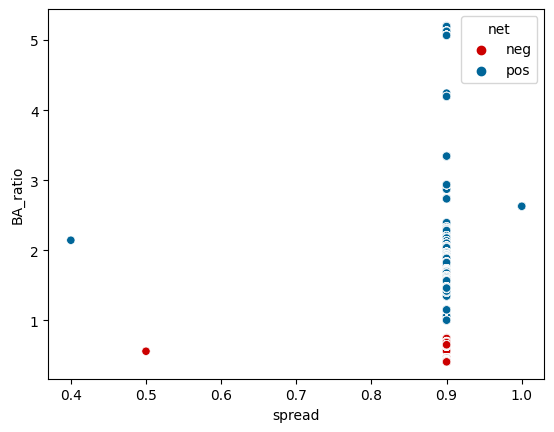

In [ ]:
sns.scatterplot(data = ba_anomaly,x= 'spread', y = 'BA_ratio',  hue = 'net', hue_order = ['neg', 'pos'],
                    palette = bidask_color)

## Net Size


In [ ]:
ba1['net_size'] = ba1['VolBid5'] - ba1['VolAsk1']
ba1['net'] = ['neg' if x < 0 else 'pos' for x in ba1['net_size'].values]

<Axes: ylabel='WAP'>

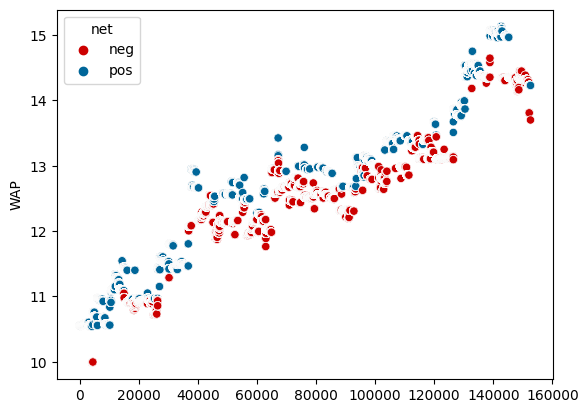

In [ ]:
# plot net_size - wap
sns.scatterplot(data = ba1,x= ba1.index, y = 'WAP',  hue = 'net', hue_order = ['neg', 'pos'],
                    palette = bidask_color)

<Axes: xlabel='Bid5', ylabel='Ask1'>

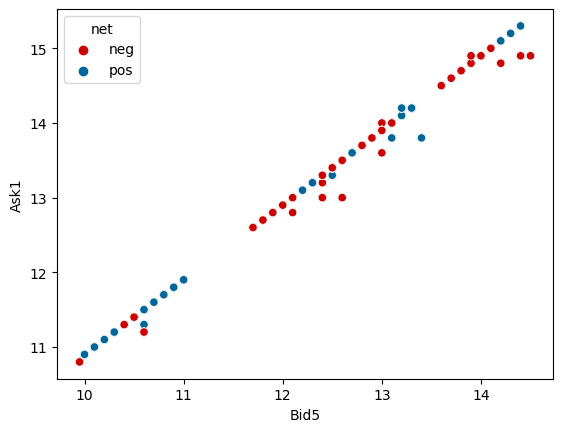

In [ ]:
sns.scatterplot(data = ba1,x= 'Bid5', y = 'Ask1',  hue = 'net', hue_order = ['neg', 'pos'],
                    palette = bidask_color)

In [ ]:
#bid ask ratio
ba1['BA_ratio'] = ba1['VolBid5'] / ba1['VolAsk1']

<Axes: xlabel='Time'>

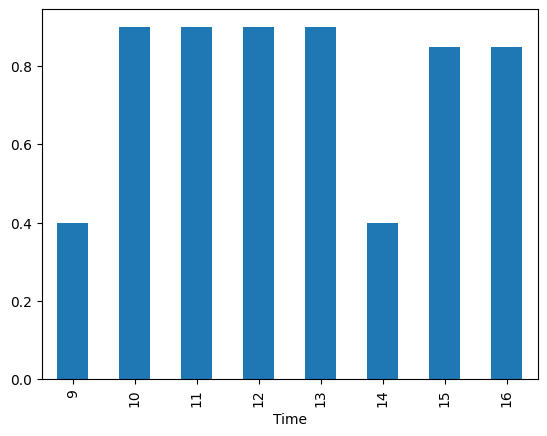

In [ ]:
#spread ต่ำในแต่ละช่วงเวลา
ba1.groupby(ba1.Time.dt.hour)['spread'].min().plot.bar()

<Axes: xlabel='Time'>

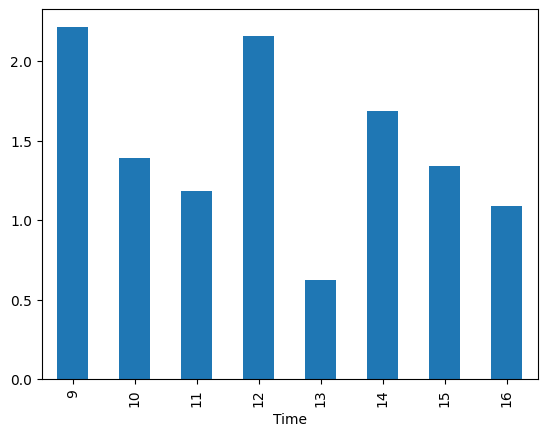

In [ ]:
#bid ask ratio ในแต่ละช่วงเวลา
ba1.groupby(ba1.Time.dt.hour)['BA_ratio'].mean().plot.bar()

<Axes: xlabel='spread', ylabel='BA_ratio'>

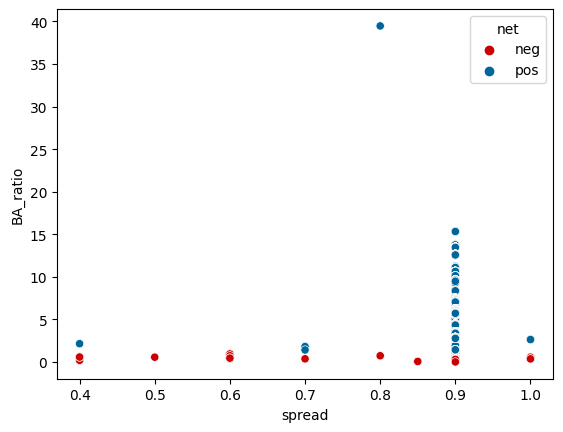

In [ ]:
# plot wap - bid/ask ratio
sns.scatterplot(data = ba1,x= 'spread', y = 'BA_ratio',  hue = 'net', hue_order = ['neg', 'pos'],
                    palette = bidask_color)

In [ ]:
#Stock Custering
